## Import Library

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
import cv2

In [2]:
import keras
import keras_vggface
import keras_vggface.utils
from keras_vggface.vggface import VGGFace
from keras import Model
from keras import layers
from keras.layers import Flatten, Input, Dropout
from keras.layers.core import Dense
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator

In [3]:
import mtcnn
from mtcnn.mtcnn import MTCNN
from keras_vggface.utils import preprocess_input
from scipy.spatial.distance import cosine

## Load Pre-trained Model

In [4]:
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [5]:
model.trainable = False

In [6]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2),
])

In [7]:
# Choose `avg_pool` as the last layer of your base model
last_layer = model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 1, 1, 2048)


In [8]:
inputs = Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = model(x)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dense(1024, activation='relu', name='fc3')(x) 
x = Dense(512, activation='relu', name='fc4')(x) 
x = Dense(512, activation='relu', name='fc5')(x) 
x = Dense(256, activation='relu', name='fc6')(x)
x = Dense(128, activation='relu', name='fc7')(x)
x = Dropout(0.2)(x)
out = Dense(105, name='classifier')(x)

In [9]:
custom_model = Model(inputs, out)

## Prepare Dataset

In [10]:
# Define our example directories and files
base_dir = 'C:\\Users\\ACER\\Capstone\\dataset\\image_sorted'

train_dir = os.path.join( base_dir, 'train')
test_dir = os.path.join( base_dir, 'test')

In [11]:
train_dataset = keras.utils.image_dataset_from_directory(train_dir,
                                                         shuffle=True,
                                                         batch_size=8,
                                                         image_size=(224, 224))

test_dataset = keras.utils.image_dataset_from_directory(test_dir,
                                                         shuffle=True,
                                                         batch_size=8,
                                                         image_size=(224, 224))

Found 4200 files belonging to 105 classes.
Found 1050 files belonging to 105 classes.


## Set Optimizer and Loss Functions

In [12]:
learning_rate = 0.0001
custom_model.compile(optimizer=RMSprop(learning_rate=learning_rate), 
                     loss=SparseCategoricalCrossentropy(from_logits=True), 
                     metrics=['accuracy'])

## Set Callback

In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        '''
        Halts the training after reaching 60 percent accuracy
        
        Args:
        epoch (integer) - index of epoch (required but unused in the function definition below)
        logs (dict) - metric results from the training epoch
        '''
        # Check accuracy
        if(logs.get('loss') < 0.7):
            # Stop if threshold is met
            print("\nLoss is lower than 0.7 so cancelling training!")
            self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

## Train Model

In [14]:
history = custom_model.fit(train_dataset, 
                           validation_data=test_dataset, 
                           steps_per_epoch = len(train_dataset),
                           epochs = 50,
                           validation_steps = len(test_dataset),
                           verbose = 2, 
                           callbacks=[callbacks])

Epoch 1/50
525/525 - 153s - loss: 4.0137 - accuracy: 0.1233 - val_loss: 1.9053 - val_accuracy: 0.5981 - 153s/epoch - 292ms/step
Epoch 2/50
525/525 - 153s - loss: 2.4181 - accuracy: 0.4271 - val_loss: 0.7836 - val_accuracy: 0.8162 - 153s/epoch - 292ms/step
Epoch 3/50
525/525 - 154s - loss: 1.8702 - accuracy: 0.5583 - val_loss: 0.3833 - val_accuracy: 0.9067 - 154s/epoch - 293ms/step
Epoch 4/50
525/525 - 155s - loss: 1.6569 - accuracy: 0.6052 - val_loss: 0.3262 - val_accuracy: 0.9133 - 155s/epoch - 296ms/step
Epoch 5/50
525/525 - 157s - loss: 1.5129 - accuracy: 0.6395 - val_loss: 0.2619 - val_accuracy: 0.9305 - 157s/epoch - 298ms/step
Epoch 6/50
525/525 - 156s - loss: 1.4214 - accuracy: 0.6612 - val_loss: 0.2417 - val_accuracy: 0.9381 - 156s/epoch - 297ms/step
Epoch 7/50
525/525 - 155s - loss: 1.3415 - accuracy: 0.6783 - val_loss: 0.2392 - val_accuracy: 0.9362 - 155s/epoch - 295ms/step
Epoch 8/50
525/525 - 156s - loss: 1.2644 - accuracy: 0.7029 - val_loss: 0.2417 - val_accuracy: 0.9390 - 

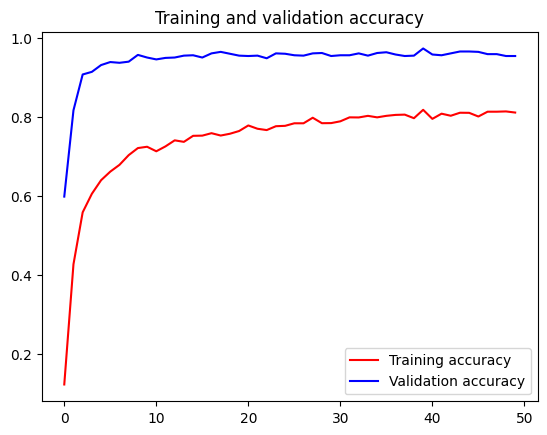

<Figure size 640x480 with 0 Axes>

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Extractor

In [16]:
def extract_face(filename, required_size=(224, 224)):
    # load image from file
    pixels = plt.imread(filename)
    
    # create the detector, using default weights
    detector = MTCNN()
    
    # detect faces in the image
    results = detector.detect_faces(pixels)
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

## Verification Check

### With Fine-Tuning

In [17]:
filenames = ["C:\\Users\\ACER\\Capstone\\verification\\olla1.jpg" , 
             "C:\\Users\\ACER\\Capstone\\verification\\gita2.jpg"]

faces = [extract_face(f) for f in filenames]
samples = np.asarray(faces, "float32")
samples = preprocess_input(samples, version=2)

# perform prediction
embeddings = custom_model.predict(samples)
thresh = 0.0015
score = cosine(embeddings[0], embeddings[1])
if score <= thresh:
    print( " >face is a match (%.4f <= %.4f) " % (score, thresh))
else:
    print(" >face is NOT a match (%.4f > %.4f)" % (score, thresh))

1/1 [==============================] - 1s 638ms/step
 >face is NOT a match (0.0049 > 0.0015)


### Without Fine-Tuning

In [ ]:
filenames = ["C:\\Users\\ACER\\Capstone\\verification3\\irene1.jpg" , 
             "C:\\Users\\ACER\\Capstone\\verification3\\irene2.jpg"]

faces = [extract_face(f) for f in filenames]
samples = np.asarray(faces, "float32")
samples = preprocess_input(samples, version=2)
model = VGGFace(model= "resnet50" , include_top=False, input_shape=(224, 224, 3), pooling= "avg" )

# perform prediction
embeddings = model.predict(samples)
thresh = 0.5
score = cosine(embeddings[0], embeddings[1])
if score <= thresh:
    print( " >face is a match (%.3f <= %.3f) " % (score, thresh))
else:
    print(" >face is NOT a match (%.3f > %.3f)" % (score, thresh))

## Save the Model

In [18]:
custom_model.save('model/model-7-8105.h5')

## Convert Model to Tflite

In [19]:
vggface_resnet_converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
vggface_resnet_converter.optimizations = [tf.lite.Optimize.DEFAULT]
vggface_resnet_tflite = vggface_resnet_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpqa5dotvf\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpqa5dotvf\assets


### Save the Tflite File

In [ ]:
with open('model/model-6.tflite', 'wb') as f:
    f.write(vggface_resnet_tflite)